In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Load datasets
customers = pd.read_csv("/content/drive/My Drive/Zeotap/Customers.csv")
products = pd.read_csv("/content/drive/My Drive/Zeotap/Products.csv")
transactions = pd.read_csv("/content/drive/My Drive/Zeotap/Transactions.csv")

In [4]:
# Remove ï»¿ from column names
customers.columns = customers.columns.str.replace('ï»¿', '')
products.columns = products.columns.str.replace('ï»¿', '')
transactions.columns = transactions.columns.str.replace('ï»¿', '')

# Check for 'CustomerID' column in both DataFrames (Verification)
print("Columns in customers:", customers.columns)
print("Columns in transactions:", transactions.columns)


Columns in customers: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Columns in transactions: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')


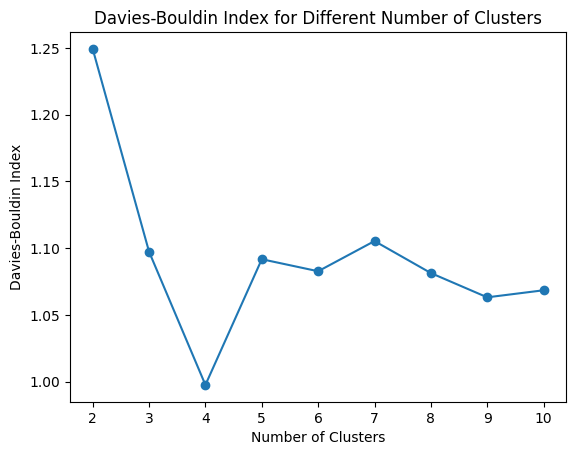

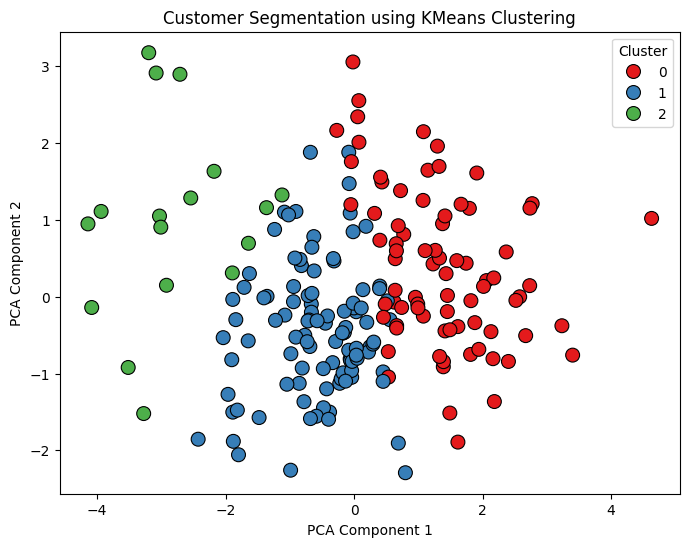

Number of clusters formed: 3
Davies-Bouldin Index for the chosen number of clusters: 1.0973


In [7]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Load the data

# Data Preprocessing
# Convert TransactionDate to datetime
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge the customer and transaction data
merged_data = pd.merge(transactions, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Feature Engineering
# 1. Total Spend (TotalValue)
total_spend = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spend.columns = ['CustomerID', 'TotalSpend']

# 2. Frequency of purchases (Number of transactions)
frequency = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# 3. Recency of last purchase (days since last purchase)
last_purchase = merged_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase['Recency'] = (pd.to_datetime('today') - last_purchase['LastPurchaseDate']).dt.days
last_purchase = last_purchase[['CustomerID', 'Recency']]

# 4. Average transaction value
avg_transaction_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.columns = ['CustomerID', 'AvgTransactionValue']

# Merge all the features
customer_features = total_spend.merge(frequency, on='CustomerID', how='left')
customer_features = customer_features.merge(last_purchase[['CustomerID', 'Recency']], on='CustomerID', how='left')
customer_features = customer_features.merge(avg_transaction_value, on='CustomerID', how='left')

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features[['TotalSpend', 'Frequency', 'Recency', 'AvgTransactionValue']])

# Apply KMeans Clustering
# Try different numbers of clusters and use the Davies-Bouldin index to evaluate
db_scores = []
range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(features_scaled)
    db_score = davies_bouldin_score(features_scaled, customer_features['Cluster'])
    db_scores.append(db_score)

# Plot Davies-Bouldin scores to find the optimal number of clusters
plt.plot(range_n_clusters, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Select the optimal number of clusters (e.g., let's assume 3 clusters after visual inspection)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features_scaled)

# Add cluster labels back to the customer data
customers_clustered = pd.merge(customers, customer_features[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Visualize the clusters using PCA (2D projection)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_features['Cluster'], palette='Set1', s=100, edgecolor='k')
plt.title('Customer Segmentation using KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Output the clustered customers data
customers_clustered.to_csv("Clustered_Customers.csv", index=False)

# Report: Clustering Summary
num_clusters = optimal_clusters
db_index = db_scores[range_n_clusters.index(optimal_clusters)]
print(f"Number of clusters formed: {num_clusters}")
print(f"Davies-Bouldin Index for the chosen number of clusters: {db_index:.4f}")


In [11]:
# Print Cluster Distribution (Number of Customers in Each Cluster)
cluster_distribution = customer_features['Cluster'].value_counts().sort_index()
print("Cluster Distribution (Number of customers in each cluster):")
print(cluster_distribution)

# Show PCA Components (for first two components) for each customer
print("\nPCA Components (first two components) for each customer:")
pca_df = pd.DataFrame(pca_components, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['CustomerID'] = customer_features['CustomerID']
pca_df['Cluster'] = customer_features['Cluster']
print(pca_df.head())  # Show the first 5 customers for illustration
print("\n")

# Show Cluster Centroids in the PCA-reduced space
# Calculate the cluster centroids in the original feature space
cluster_centroids_original = kmeans.cluster_centers_

# Transform the centroids to the PCA-reduced space (2D)
cluster_centroids_pca = pca.transform(cluster_centroids_original)

# Display the cluster centroids in PCA space
centroids_df = pd.DataFrame(cluster_centroids_pca, columns=['PCA Component 1', 'PCA Component 2'], index=[f'Cluster {i+1}' for i in range(optimal_clusters)])
print("Cluster Centroids in the PCA-reduced space:")
print(centroids_df)



# Davies-Bouldin Index
num_clusters = optimal_clusters
db_index = db_scores[range_n_clusters.index(optimal_clusters)]
print(f"\nNumber of clusters formed: {num_clusters}")
print(f"Davies-Bouldin Index for the chosen number of clusters: {db_index:.4f}")


Cluster Distribution (Number of customers in each cluster):
Cluster
0     78
1    104
2     17
Name: count, dtype: int64

PCA Components (first two components) for each customer:
   PCA Component 1  PCA Component 2 CustomerID  Cluster
0         0.031957        -0.196448      C0001        1
1        -0.855328        -1.128049      C0002        1
2        -0.820778         0.403622      C0003        1
3         1.812192        -0.751722      C0004        0
4        -0.944593        -0.066417      C0005        1


Cluster Centroids in the PCA-reduced space:
           PCA Component 1  PCA Component 2
Cluster 1         1.351880         0.379131
Cluster 2        -0.555523        -0.447274
Cluster 3        -2.804250         0.996718

Number of clusters formed: 3
Davies-Bouldin Index for the chosen number of clusters: 1.0973
